#   РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ  
### PROJECT: EXPLORATORY DATA ANALYSIS (EDA)

### Цель:
Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

### План:  
1. Импорт и вспомогательные функции  
2. Первичный осмотр данных   
3. Анализ категориальных и числовых столбцов 
4. Корреляционный анализ  
5. Анализ номинативных переменных  
6. Выводы

# 1. Импорт данных и вспомогательные функции

In [610]:
# Импортируем необходимые библиотеки и установим количество отображаемых строк и столбцов по умолчанию
import pandas as pd
import numpy as np
from itertools import combinations
 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, norm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import statsmodels.formula.api as sm 

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
plt.rcParams['figure.figsize'] = (4.5, 3.5)

In [611]:
def column_info(DF, col):
    # функция для вывода информации о колонке
    # DF - датафрейм,col - имя колонки 
    display(pd.DataFrame(DF[col].value_counts()))
    print('\nУникальных значений:', DF[col].nunique())
    if len(DF[col].unique()) < 30:
        print(f'Уникальные значения: {DF[col].unique()}')
    else:
        print(f'Некоторые уникальные значения: {DF[col].unique()[:30]}')
    if DF[col].isna().sum() !=0:
        print(f'Пропущенных значений: {DF[col].isna().sum()} из {len(DF[col])}, что составляет: {round(100 * DF[col].isna().sum() /len(DF[col]),2)}%\n')
    else:
        print(f'Пропущенных значений: {DF[col].isna().sum()}\n')
    display(DF[col].info())

In [612]:
def outliers_z_score(ys, threshold=3):
    # Функция для определения выбросов. Поиск по отклонению (z-score)
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores =  [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [613]:
def outliers_iqr(ys):
    # Функция для определения выбросов. Формула межквартильного расстояния 
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])   # vis_data.distance.quantile([0.25, 0.75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [614]:
def estimate_gaussian(dataset):
    # Функция для определения выбросов. Поиск по распределению
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def get_gaussian(mu, sigma):
    distribution = norm(mu, sigma)
    return distribution

def get_probs(distribution, dataset):
    return distribution.pdf(dataset)

In [615]:
def get_distplot(df, x, bins=20):
    # Функция для потроения дистплота
    ax = sns.distplot(df, x=df[x], bins=20)
    ax.set_title(x)

In [616]:
def get_boxplot(DF, column, parameter):
    # функция для быстрого построения боксплотов
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(
                x=column, y=parameter,
                data=DF.loc[DF.loc[:, column].isin(DF.loc[:, column].value_counts().index[:10])],
                ax=ax, flierprops={"marker": "x"}, medianprops={"color": "coral"},
                 )
    plt.xticks(rotation=90)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [617]:
def BruteForce(params: set, formula: str, result: set) -> str:
    # Функция для нахождения набора переменных, обеспечивающих максимальный R-squared
    if not params:
        result.add(formula.lstrip('+ '))
        return
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)
            BruteForce(new_params, formula + ' + ' + el, result)
            BruteForce(new_params, formula, result)

In [618]:
def stat_dif_bonf(DF, column, parameter):
    # Функция для множественного сравнения в классическом варианте дисперсионного анализа
    cols = DF.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(DF.loc[DF.loc[:, column] == comb[0], parameter],
                     DF.loc[DF.loc[:, column] == comb[1], parameter]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print(f'- Найдены статистически значимые различия для переменной "{column}": {comb[1]}, {comb[0]}.')
            # break

In [619]:
def stat_dif_tukey(DataFrame, columns_in, columns_predict, most_popular_num, alpha):
    # Критерий Тьюки для множественных сравнений ANOVA (однофакторного дисперсионного анализа)
    result = pd.DataFrame()     # Итоговый датафрейм
    for col in columns_in:
        df = DataFrame.loc[DataFrame.loc[:, col].isin(
            DataFrame.loc[:, col].value_counts().index[:most_popular_num])]
        df = df[[columns_predict, col]]
        df = df.dropna()     # Избавимся от выбросов, т.к. statsmodels не может работать с пустыми значениями

        MultiComp = MultiComparison(df[columns_predict], df[col])
        MC = pd.DataFrame(MultiComp.tukeyhsd(alpha).summary())
        MC = MC.loc[1:]

        MC.columns = ['group1', 'group2', 'meandiff',
                      'p-adj', 'lower', 'upper', 'reject']
        MC.group1 = MC.group1.astype('str')
        MC.group2 = MC.group2.astype('str')
        MC.meandiff = MC.meandiff.astype('str')
        MC.meandiff = MC.meandiff.astype('float64')
        MC['p-adj'] = MC['p-adj'].astype('str')
        MC['p-adj'] = MC['p-adj'].astype('float64')
        MC['lower'] = MC['lower'].astype('str')
        MC['lower'] = MC['lower'].astype('float64')
        MC['upper'] = MC['upper'].astype('str')
        MC['upper'] = MC['upper'].astype('float64')
        MC['reject'] = MC['reject'].astype('str')
        MC[MC.reject == 'True']
        MC.reject = MC.reject.apply(lambda x: True if x == 'True' else False)
        MC['feature'] = col     # Признак, по которому найдено различие в группах
        result = result.append(MC)
    display(result[result.reject == True])
    print(f"Найдены статистически значимые различия в: \n{result[result.reject == True].feature.value_counts()}")

# 2. Первичный осмотр данных

In [620]:
# Загрузим данные и посмотрим на датасет
df = pd.read_csv('math_study.csv')
display(df)
display(df.info())
print(f"Размер датасета: {df.shape}\n")
print(f'\nКоличество уникальных значений: \n{df.nunique()}')
print('\nКоличество пропущенных значений:')
for col in df.columns:
    if df[col].isna().sum() >0:
        print(col, ':', df[col].isna().sum())
display(df.describe())
display(df.describe(include='object'))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

Размер датасета: (395, 30)


Количество уникальных значений: 
school                  2
sex                     2
age                     8
address                 2
famsize                 2
Pstatus                 2
Medu                    5
Fedu                    6
Mjob                    5
Fjob                    5
reason                  4
guardian                3
traveltime              4
studytime               4
failures                4
schoolsup               2
famsup                  2
paid                    2
activities              2
nursery                 2
studytime, granular     4
higher                  2
internet                2
romantic                2
famrel                  6
freetime                5
goout                   5
health                  5
absences               36
score                  18
dtype: int64

Количество пропущенных значений:
address : 17
famsize : 27
Pstatus : 45
Medu : 3
Fedu : 24
Mjob : 19
Fjob : 36
reason : 17
guardian : 31
travelt

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,378,368,350,376,359,378,364,386,356,355,381,379,375,361,364
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,295,261,314,133,197,137,250,335,219,200,195,300,356,305,240


### Содержание датасета:
1. **school** — аббревиатура школы, в которой обучается ученик

2. **sex** — пол ученика (**'F'** - женский, **'M'** - мужской)

3. **age** — возраст ученика **(от 15 до 22)**

4. **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом)

5. **famsize** — размер семьи (**'LE3'** <= 3, **'GT3'** >3)

6. **Pstatus** — статус совместного проживания родителей (**'T'** - живут вместе **'A'** - раздельно)

7. **Medu** — образование матери (**0** - нет, **1** - окончила 4 класса, **2** - окончила 5-9 классов, **3** - среднее специальное или 11 классов, **4** - высшее)

8. **Fedu** — образование отца (**0** - нет, **1** - окончил 4 класса, **2** - окончил 5-9 классов, **3** - среднее специальное или 11 классов, **4** - высшее)

9. **Mjob** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, **'services'** - госслужба, **'at_home'** - не работает, **'other'** - другое)

10. **Fjob** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, **'services'** - госслужба, **'at_home'** - не работает, **'other'** - другое)

11. **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, **'course'** - образовательная программа, **'other'** - другое)

12. **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое)

13. **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., **3** - 30-60 мин., **4** - >60 мин.)

14. **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, **3** - 5-10 часов, **4** - >10 часов)

15. **failures** — количество внеучебных неудач (**n**, если 1<=n<=3, иначе **0**)

16. **schoolsup** — дополнительная образовательная поддержка **(yes или no)**

17. **famsup** — семейная образовательная поддержка **(yes или no)**

18. **paid** — дополнительные платные занятия по математике **(yes или no)**

19. **activities** — дополнительные внеучебные занятия **(yes или no)**

20. **nursery** — посещал детский сад **(yes или no)**

21. **higher** — хочет получить высшее образование **(yes или no)**

22. **internet** — наличие интернета дома **(yes или no)**

23. **romantic** — в романтических отношениях **(yes или no)**

24. **famrel** — семейные отношения **(от 1 - очень плохо до 5 - очень хорошо)**

25. **freetime** — свободное время после школы (**от 1 - очень мало до 5 - очень мого)**

26. **goout** — проведение времени с друзьями **(от 1 - очень мало до 5 - очень много)**

27. **health** — текущее состояние здоровья **(от 1 - очень плохо до 5 - очень хорошо)**

28. **absences** — количество пропущенных занятий

29. **score** — баллы по госэкзамену по математике - целевая переменная

**Столбец 'studytime, granular'** в описании проекта не представлен. На данный момент не известно, что он обозначает. Возможно, позже мы увидим, что его можно просто удалить.

In [621]:
# Преобразуем названия колонок для удобства
display(df.columns)  
print(f'Переименуем столбец "studytime, granular"  в  "granular" для удобства')
df.rename(columns = {'studytime, granular' : 'granular'}, inplace = True)
df.columns 

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Переименуем столбец "studytime, granular"  в  "granular" для удобства


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
       'goout', 'health', 'absences', 'score'],
      dtype='object')

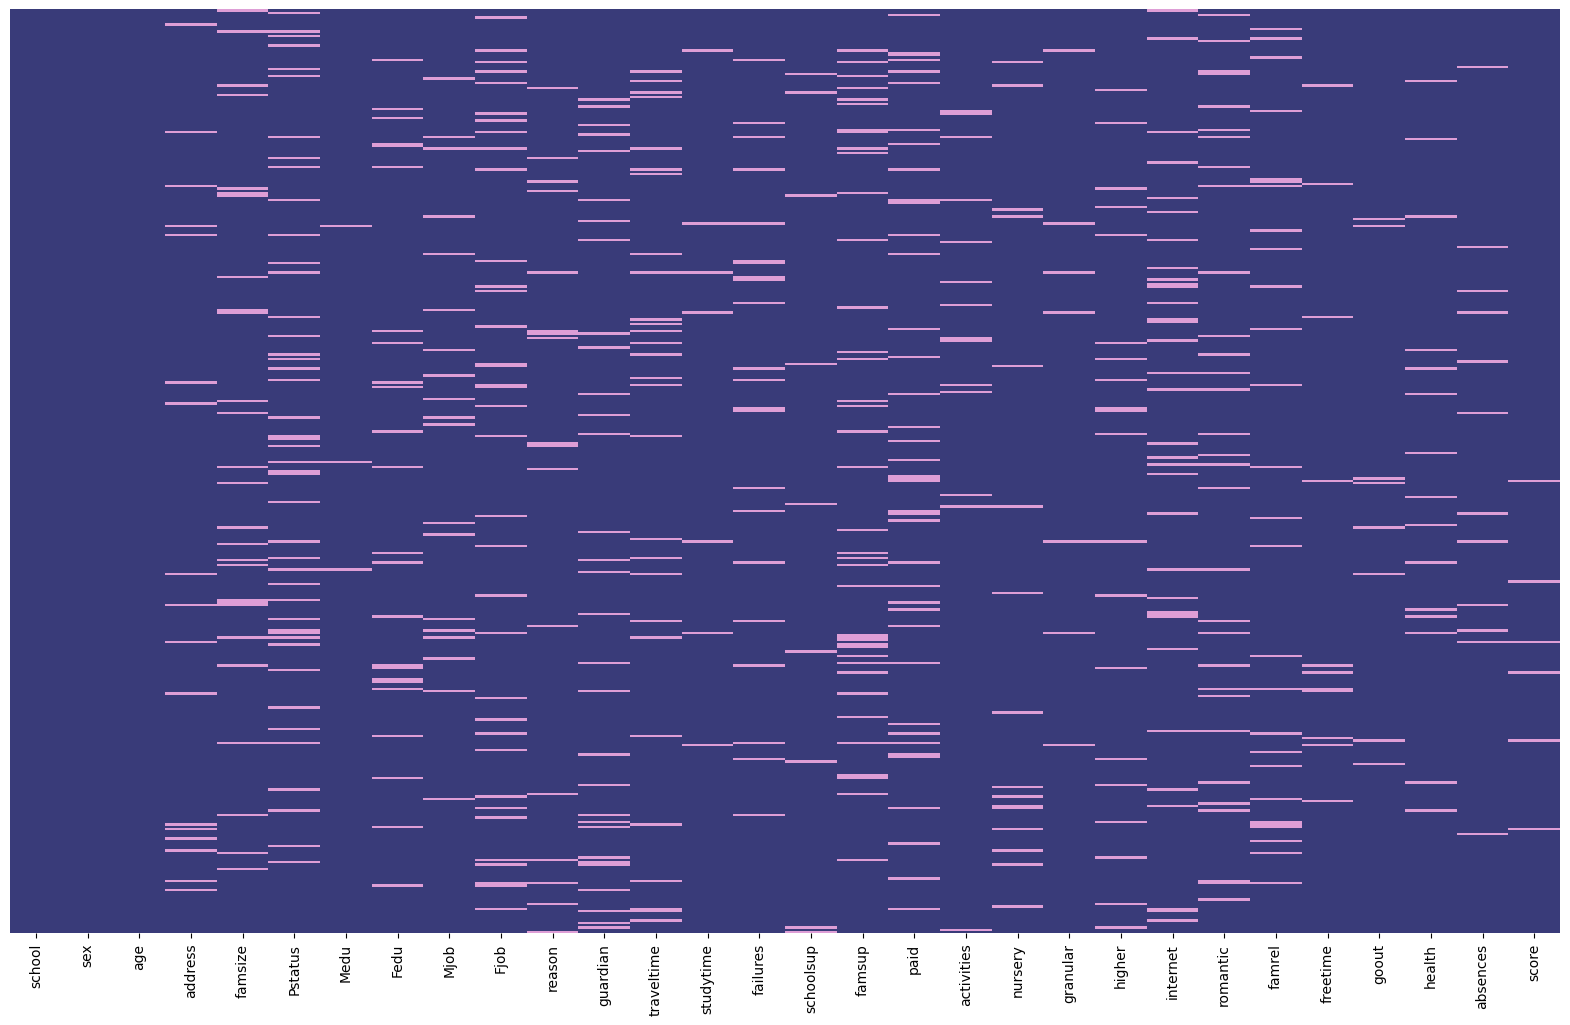

In [622]:
# Оценим визуально количество пропусков и их распределение
fig, ax = plt.subplots(figsize=(20,12))   
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='tab20b')

# 3. Анализ категориальных и числовых столбцов

### Рассмотрим категориальные столбцы

In [623]:
# Выведем названия всех категориальных столбцов
for col in df.columns:
    if df[col].dtype == 'object':
        print(col)

school
sex
address
famsize
Pstatus
Mjob
Fjob
reason
guardian
schoolsup
famsup
paid
activities
nursery
higher
internet
romantic


In [624]:
# Применим функцию info_column, чтобы детальнее посмотреть на данные в категориалных столбцах
for col in df.columns:
    if df[col].dtype == 'object':
        column_info(df, col)

,school
GP,349
MS,46



Уникальных значений: 2
Уникальные значения: ['GP' 'MS']
Пропущенных значений: 0

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: school
Non-Null Count  Dtype 
--------------  ----- 
395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,sex
F,208
M,187



Уникальных значений: 2
Уникальные значения: ['F' 'M']
Пропущенных значений: 0

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: sex
Non-Null Count  Dtype 
--------------  ----- 
395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,address
U,295
R,83



Уникальных значений: 2
Уникальные значения: ['U' nan 'R']
Пропущенных значений: 17 из 395, что составляет: 4.3%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: address
Non-Null Count  Dtype 
--------------  ----- 
378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,famsize
GT3,261
LE3,107



Уникальных значений: 2
Уникальные значения: [nan 'GT3' 'LE3']
Пропущенных значений: 27 из 395, что составляет: 6.84%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: famsize
Non-Null Count  Dtype 
--------------  ----- 
368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,Pstatus
T,314
A,36



Уникальных значений: 2
Уникальные значения: ['A' nan 'T']
Пропущенных значений: 45 из 395, что составляет: 11.39%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: Pstatus
Non-Null Count  Dtype 
--------------  ----- 
350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,Mjob
other,133
services,98
at_home,58
teacher,55
health,32



Уникальных значений: 5
Уникальные значения: ['at_home' 'health' 'other' 'services' 'teacher' nan]
Пропущенных значений: 19 из 395, что составляет: 4.81%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: Mjob
Non-Null Count  Dtype 
--------------  ----- 
376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,Fjob
other,197
services,102
teacher,29
at_home,16
health,15



Уникальных значений: 5
Уникальные значения: ['teacher' 'other' nan 'health' 'services' 'at_home']
Пропущенных значений: 36 из 395, что составляет: 9.11%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: Fjob
Non-Null Count  Dtype 
--------------  ----- 
359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,reason
course,137
home,104
reputation,103
other,34



Уникальных значений: 4
Уникальные значения: ['course' 'other' 'home' 'reputation' nan]
Пропущенных значений: 17 из 395, что составляет: 4.3%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: reason
Non-Null Count  Dtype 
--------------  ----- 
378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,guardian
mother,250
father,86
other,28



Уникальных значений: 3
Уникальные значения: ['mother' 'father' 'other' nan]
Пропущенных значений: 31 из 395, что составляет: 7.85%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: guardian
Non-Null Count  Dtype 
--------------  ----- 
364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,schoolsup
no,335
yes,51



Уникальных значений: 2
Уникальные значения: ['yes' 'no' nan]
Пропущенных значений: 9 из 395, что составляет: 2.28%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: schoolsup
Non-Null Count  Dtype 
--------------  ----- 
386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,famsup
yes,219
no,137



Уникальных значений: 2
Уникальные значения: ['no' 'yes' nan]
Пропущенных значений: 39 из 395, что составляет: 9.87%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: famsup
Non-Null Count  Dtype 
--------------  ----- 
356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,paid
no,200
yes,155



Уникальных значений: 2
Уникальные значения: ['no' nan 'yes']
Пропущенных значений: 40 из 395, что составляет: 10.13%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: paid
Non-Null Count  Dtype 
--------------  ----- 
355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,activities
yes,195
no,186



Уникальных значений: 2
Уникальные значения: ['no' 'yes' nan]
Пропущенных значений: 14 из 395, что составляет: 3.54%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: activities
Non-Null Count  Dtype 
--------------  ----- 
381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,nursery
yes,300
no,79



Уникальных значений: 2
Уникальные значения: ['yes' 'no' nan]
Пропущенных значений: 16 из 395, что составляет: 4.05%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: nursery
Non-Null Count  Dtype 
--------------  ----- 
379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,higher
yes,356
no,19



Уникальных значений: 2
Уникальные значения: ['yes' nan 'no']
Пропущенных значений: 20 из 395, что составляет: 5.06%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: higher
Non-Null Count  Dtype 
--------------  ----- 
375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,internet
yes,305
no,56



Уникальных значений: 2
Уникальные значения: [nan 'yes' 'no']
Пропущенных значений: 34 из 395, что составляет: 8.61%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: internet
Non-Null Count  Dtype 
--------------  ----- 
361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

,romantic
no,240
yes,124



Уникальных значений: 2
Уникальные значения: ['no' nan 'yes']
Пропущенных значений: 31 из 395, что составляет: 7.85%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: romantic
Non-Null Count  Dtype 
--------------  ----- 
364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


None

### Рассмотрим числовые столбцы  

**Выведем названия всех числовых столбцов и рассмотрим каждый их них более детально**

In [625]:
# Выведем названия всех числовых столбцов
for col in df.columns:
    if df[col].dtype != 'object':
        print(col)

age
Medu
Fedu
traveltime
studytime
failures
granular
famrel
freetime
goout
health
absences
score


### Столбец 'age'

Количество уникальных значений в столбце "age": 8.
Уникальные значения: [15, 16, 17, 18, 19, 20, 21, 22].


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

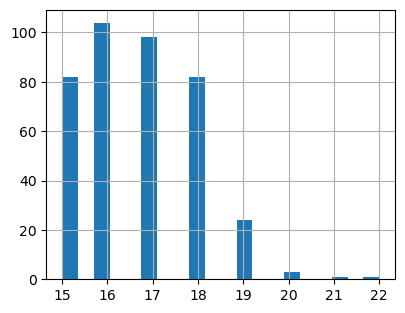

In [626]:
# Посмотрим на значения описательных статистик и построим гистограмму распределения 
print(f'Количество уникальных значений в столбце "age": {df.age.nunique()}.\nУникальные значения: {sorted(df.age.unique())}.')
df.age.hist(bins=20)
display(df.age.describe())

<AxesSubplot:xlabel='age'>

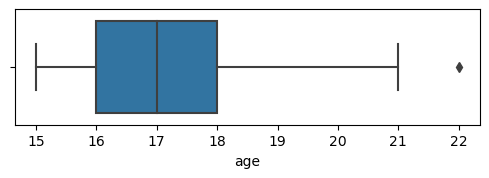

In [627]:
plt.figure(figsize=(6,1.5))
sns.boxplot(data=df, x='age')

График boxplot показывает, что значение возраста "22" может являться выбросом.  
Воспользуемся тремя различными способами определения выбросов:   
- поиском по отклонению (z-score),   
- формулой интерквартильного расстояния (межквартильного размаха)   
- поиском по распределению.   

Все функции помещены в начало проекта в раздел "Импорт данных и вспомогательные функции".

**Поиск выбросов по отклонению (z-score)**   
Этот метод основан на поиске значения, на которое отклоняется данная точка от среднего. В таком случае используют z-score, то есть, расстояние (измеряемое в количестве стандартных отклонений) от среднего значения точек.

In [628]:
outliers = outliers_z_score(df.age, threshold=3)
print(f'Количество выявленных выбросов с помощью z-score: {len(outliers)}\n\nЗначения, определенные как выбросы:')
df.age.iloc[outliers].to_frame()

Количество выявленных выбросов с помощью z-score: 2

Значения, определенные как выбросы:


,age
247,22
392,21


**Формула межквартильного расстояния**  
Выбросами считаются значения, которые лежат вне рамок: [percentile(25) -1.5 * IQR : percentile(75)+1.5 * IQR], где IQR = percentile(75) - percentile(25).

In [629]:
outliers = outliers_iqr(df.age)
print(f'Количество выявленных выбросов с помощью формулы межквартильного расстояния: {len(outliers)}\n\nЗначения, определенные как выбросы:')
df.age.iloc[outliers].to_frame()

Количество выявленных выбросов с помощью формулы межквартильного расстояния: 1

Значения, определенные как выбросы:


,age
247,22


**Поиск по распределению**  
Построим нормальное распределение поверх данных, посчитаем вероятность находиться в данном распределении для каждого значения.  
Самые невероятные значения считаются выбросами.

In [630]:
mu, sigma = estimate_gaussian(df.age)
distribution = get_gaussian(mu, sigma)
probabilities = get_probs(distribution, df.age)
display(round(round(pd.Series(probabilities),3).value_counts(normalize=True),3).reset_index().sort_values(by='index', ascending=False))

# Выберем значение вероятности (0.03), ниже которого будем считать точку выбросом и посчитаем количество выбросов
outl = np.where(probabilities < 0.03)[0]
print(f'Количество выявленных выбросов с помощью поиска по распределению: {len(outl)}\n\nЗначения, определенные как выбросы:')
df.age.iloc[outl].to_frame()

,index,0
1,0.241,0.248
0,0.224,0.263
2,0.178,0.208
3,0.142,0.208
4,0.090,0.061
5,0.031,0.008
7,0.007,0.003
6,0.001,0.003


Количество выявленных выбросов с помощью поиска по распределению: 2

Значения, определенные как выбросы:


,age
247,22
392,21


Несмотря на тот факт, что три различные проверки определили значение возраста "22" как выброс, это значение можно не считать выбросом, т.к. заявленная **цель проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость**. Наблюдаемый минимум и максимум входят в этот промежуток по условию задачи, поэтому удалять это значение не будем.

### Столбец 'Medu'

In [631]:
# Выведем более детальную информацию о колонке
column_info(df, 'Medu')

,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3



Уникальных значений: 5
Уникальные значения: [ 4.  1.  3.  2. nan  0.]
Пропущенных значений: 3 из 395, что составляет: 0.76%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: Medu
Non-Null Count  Dtype  
--------------  -----  
392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

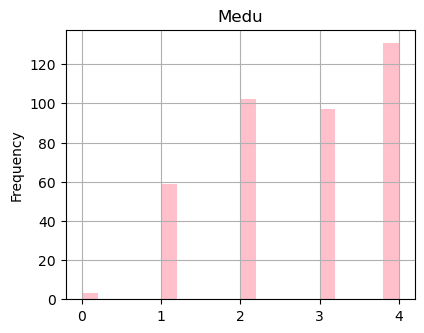

In [632]:
# Посмотрим на значения описательных статистик и построим гистограмму распределения 
df.Medu.plot(kind = 'hist', grid = True,colormap = 'coolwarm', title = 'Medu', color = 'pink', bins = 20)
display(df.Medu.describe())

### Столбец 'Fedu'

In [633]:
# Выведем более детальную информацию о колонке 
column_info(df, 'Fedu')

,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1



Уникальных значений: 6
Уникальные значения: [ 4.  1.  2.  3. 40. nan  0.]
Пропущенных значений: 24 из 395, что составляет: 6.08%

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: Fedu
Non-Null Count  Dtype  
--------------  -----  
371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


None

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

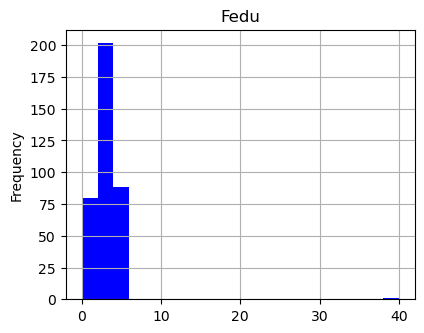

In [634]:
# Посмотрим на значения описательных статистик и построим гистограмму распределения 
df.Fedu.plot(kind = 'hist', grid = True, colormap = 'coolwarm', title = 'Fedu', color = 'blue', bins = 20)
display(df.Fedu.describe())

Судя по графику, в данных присутствует явный выброс - значение 40. Избавимся от наблюдений, которые имеют некорректное значение.

<AxesSubplot:title={'center':'Fedu'}, ylabel='Frequency'>

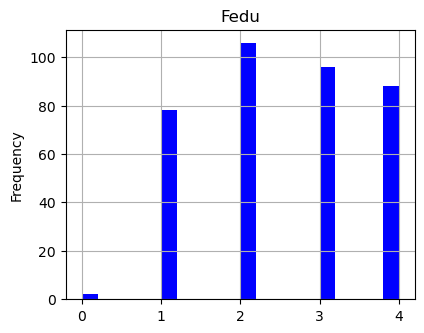

In [635]:
# df.Fedu = df['Fedu'].apply(lambda x: x if x in range(0, 5) else np.nan)
# df.Fedu.value_counts(dropna=False)

# Избавимся от наблюдений, которые имеют некорректное значение 
df = df.loc[df.Fedu < 5]
df.Fedu.plot(kind = 'hist', grid = True, legend = False, colormap = 'coolwarm', title = 'Fedu', color = 'blue', bins = 20)

### Столбец  'traveltime'

,traveltime
1.0,225
2.0,92
3.0,21
4.0,7



Уникальных значений: 4
Уникальные значения: [ 2.  1.  3. nan  4.]
Пропущенных значений: 25 из 370, что составляет: 6.76%

<class 'pandas.core.series.Series'>
Int64Index: 370 entries, 0 to 394
Series name: traveltime
Non-Null Count  Dtype  
--------------  -----  
345 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

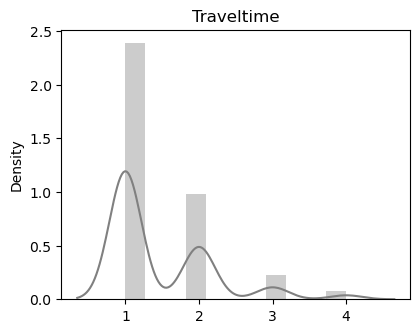

In [636]:
# Выведем более детальную информацию о колонке и построим график распределения 
ax = sns.distplot(df, x=df.traveltime, color ="gray")
ax.set_title('Traveltime')
column_info(df, 'traveltime')

### Столбец 'studytime'

,studytime
2.0,182
1.0,98
3.0,58
4.0,25



Уникальных значений: 4
Уникальные значения: [ 2.  3.  1. nan  4.]
Пропущенных значений: 7 из 370, что составляет: 1.89%

<class 'pandas.core.series.Series'>
Int64Index: 370 entries, 0 to 394
Series name: studytime
Non-Null Count  Dtype  
--------------  -----  
363 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

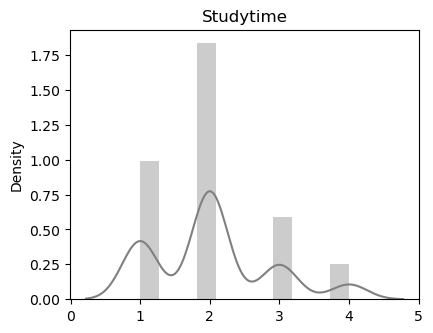

In [637]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
ax = sns.distplot(df, x=df.studytime, color ="gray")
ax.set_title('Studytime')
column_info(df, 'studytime')

### Столбец 'failures'

,failures
0.0,277
1.0,45
3.0,15
2.0,14



Уникальных значений: 4
Уникальные значения: [ 0.  3.  2.  1. nan]
Пропущенных значений: 19 из 370, что составляет: 5.14%

<class 'pandas.core.series.Series'>
Int64Index: 370 entries, 0 to 394
Series name: failures
Non-Null Count  Dtype  
--------------  -----  
351 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

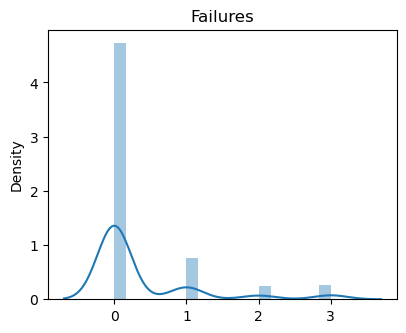

In [638]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
ax = sns.distplot(df, x=df.failures)
ax.set_title('Failures')
column_info(df,'failures')

### Столбец 'granular' 

,granular
-6.0,182
-3.0,98
-9.0,58
-12.0,25



Уникальных значений: 4
Уникальные значения: [ -6.  -9.  -3.  nan -12.]
Пропущенных значений: 7 из 370, что составляет: 1.89%

<class 'pandas.core.series.Series'>
Int64Index: 370 entries, 0 to 394
Series name: granular
Non-Null Count  Dtype  
--------------  -----  
363 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

count    363.000000
mean      -6.082645
std        2.521466
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: granular, dtype: float64

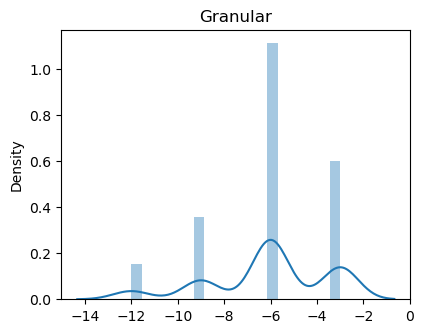

In [639]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
ax = sns.distplot(df, x=df.granular, bins=20)
ax.set_title('Granular')
column_info(df, 'granular')
df.granular.describe()

<AxesSubplot:xlabel='granular'>

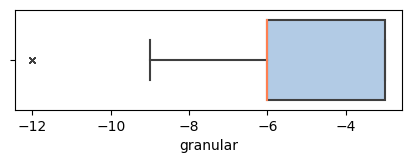

In [640]:
# Построим boxplot, чтобы взглянуть на плотность распределения и потенциальные выбросы
fig = plt.figure(figsize=(5, 1.3))
sns.boxplot(data = df, x = df.granular, flierprops={"marker": "x"}, medianprops={"color": "coral"},
            boxprops={"facecolor": (.4, .6, .8, .5)})

График boxplot показывает, что в колонке 'granular', возможно, присутствуют выбросы. Однако, в справочном материале к данному проекту об этой переменной нет какой-либо информации. Возможно, далее по ходу проведения анализа данных станет понятно, что означает эта переменная. Пока что не будем производить над ней какие-либо действия. 

### Столбец 'famrel'

,famrel
4.0,168
5.0,95
3.0,59
2.0,16
1.0,7
-1.0,1



Уникальных значений: 6
Уникальные значения: [ 4.  5.  3. nan -1.  2.  1.]
Пропущенных значений: 24 из 370, что составляет: 6.49%

<class 'pandas.core.series.Series'>
Int64Index: 370 entries, 0 to 394
Series name: famrel
Non-Null Count  Dtype  
--------------  -----  
346 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


None

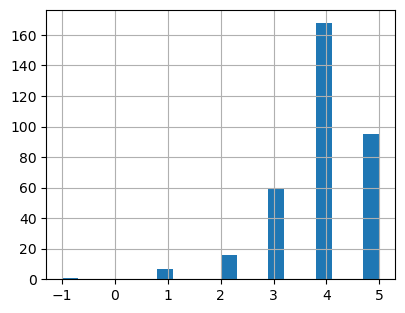

In [641]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
df.famrel.hist(bins=20, grid=True)
column_info(df, 'famrel')

Согласно справочной информации, переменная famrel — семейные отношения — имеет градацию от 1 (очень плохо) до 5 (очень хорошо).  
Значение "-1" может быть ошибкой ввода. Возможно, на этом месте должно быть значение "1". Для проверки этой гипотезы можно построить вспомогательную модель, которая выявит закономерности и определит более точное значение этого наблюдения. Однако, на данный момент мы не можем однозначно ответить на этот вопрос, поэтому избавимся от этого наблюдения.

<AxesSubplot:>

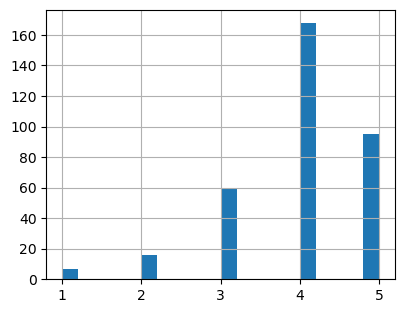

In [642]:
# Избавимся от значения признака '-1' и построим гистограмму
df = df.loc[df.famrel >0]
df.famrel.hist(bins=20)

### Столбец 'freetime'

,freetime
3.0,134
4.0,97
2.0,54
5.0,34
1.0,17



Уникальных значений: 5
Уникальные значения: [ 3.  2.  4.  1.  5. nan]
Пропущенных значений: 9 из 345, что составляет: 2.61%

<class 'pandas.core.series.Series'>
Int64Index: 345 entries, 0 to 394
Series name: freetime
Non-Null Count  Dtype  
--------------  -----  
336 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


None

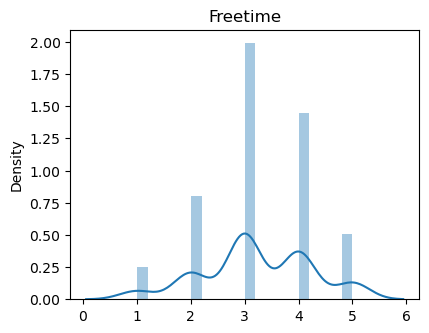

In [643]:
# Выведем более детальную информацию о колонке и построим график распределения 
ax = sns.distplot(df, x=df.freetime, bins=20)
ax.set_title('Freetime')
column_info(df, 'freetime')

### Столбец 'goout'

,goout
3.0,115
2.0,87
4.0,71
5.0,45
1.0,19



Уникальных значений: 5
Уникальные значения: [ 4.  3.  2.  1.  5. nan]
Пропущенных значений: 8 из 345, что составляет: 2.32%

<class 'pandas.core.series.Series'>
Int64Index: 345 entries, 0 to 394
Series name: goout
Non-Null Count  Dtype  
--------------  -----  
337 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


None

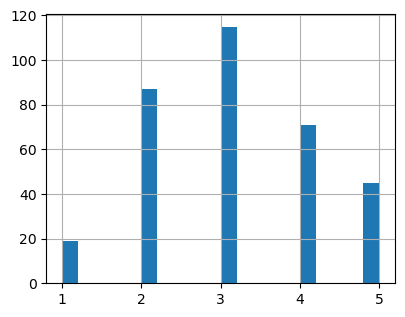

In [644]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
df.goout.hist(bins=20)
column_info(df, 'goout')

### Столбец 'health'

,health
5.0,111
3.0,81
4.0,58
1.0,42
2.0,40



Уникальных значений: 5
Уникальные значения: [ 3.  5.  1.  2.  4. nan]
Пропущенных значений: 13 из 345, что составляет: 3.77%

<class 'pandas.core.series.Series'>
Int64Index: 345 entries, 0 to 394
Series name: health
Non-Null Count  Dtype  
--------------  -----  
332 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


None

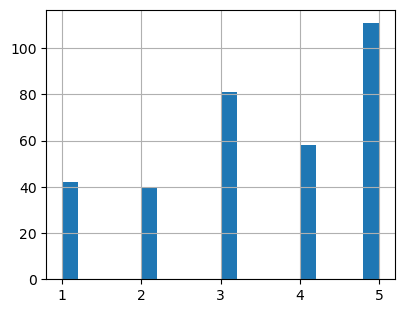

In [645]:
# Выведем более детальную информацию о колонке и построим гистограмму распределения 
df.health.hist(bins=20)
column_info(df, 'health')

### Столбец 'absences'

Количество уникальных значений признака 'absences': 33


count    333.000000
mean       7.315315
std       24.755302
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

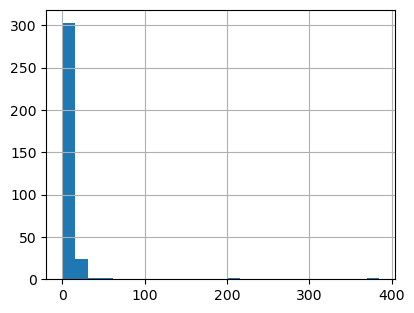

In [646]:
# Выведем значения описательных статистик и построим гистограмму распределения 
print(f"Количество уникальных значений признака 'absences': {df.absences.nunique()}")
df.absences.hist(bins=25)
df.absences.describe()

<AxesSubplot:xlabel='absences'>

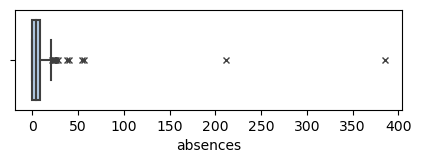

In [647]:
# Построим boxplot, чтобы взглянуть на плотность распределения и потенциальные выбросы
fig = plt.figure(figsize=(5, 1.3))
sns.boxplot(data = df, x = df.absences, flierprops={"marker": "x"},
            boxprops={"facecolor": (.4, .6, .8, .5)})

На графике видно, что данные распределены ассиметрично. Чтобы исправить ситуацию, можно взять корень, возвестив  степень или прологарифмировать переменную. **Возьмем логорифм переменной 'absences', чтобы уменьшить перепады и сгладить "хвост". (прибавим к значениям единицу, чтобы не получть "inf")**

<AxesSubplot:xlabel='absences'>

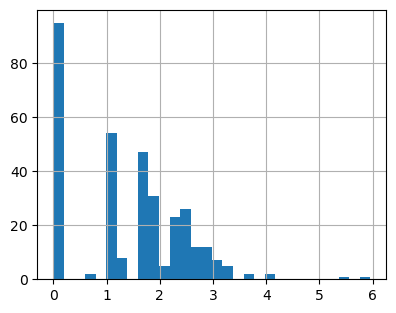

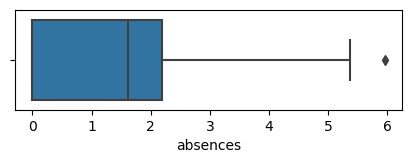

In [648]:
# Пролагорифмируем переменную и построим график
# np.log(df.absences +1)
df.absences = df.absences.apply(lambda x: np.log(x+1))

df.absences.hist(bins=30)
fig = plt.figure(figsize=(5,1.3))
sns.boxplot(data=df, x= 'absences')

### Столбец 'score' - целевая переменная

count    339.000000
mean      52.477876
std       22.556214
min        0.000000
25%       42.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Количество уникальных значений признака "score": 18
Уникальные значения в порядке возрастания: [0.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, nan]


<AxesSubplot:xlabel='score'>

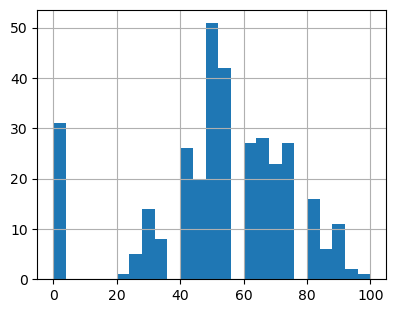

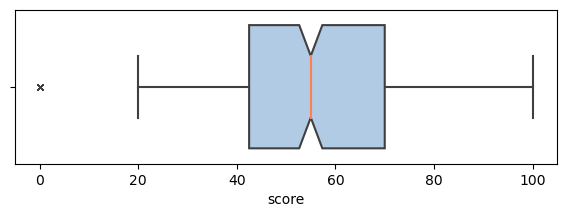

In [649]:
# Выведем значения описательных статистик и построим гистограмму распределения 
df.score.hist(bins=25)
display(df.score.describe())
print(f'Количество уникальных значений признака "score": {df.score.nunique()}\nУникальные значения в порядке возрастания: {sorted(df.score.unique())}')

# Построим boxplot, чтобы посмотреть плотность распределения и потенциальные выбросы
fig = plt.figure(figsize=(7,2))
sns.boxplot(data = df, x = df.score, flierprops={"marker": "x"}, medianprops={"color": "coral"},
            boxprops={"facecolor": (.4, .6, .8, .5)}, notch=True)

График показывает, что в данных явно присутствуют выбросы. **Посмотрим детальнее с помощью формулы межквартильного расстояния**.  
(Функция для нахождения выбросов с помощью межквартильного расстояния помещена в начало проекта в раздел "Вспомогательные функции").

In [650]:
outliers = outliers_iqr(df.score.dropna())
print(f'Количество выявленных выбросов с помощью формулы межквартильного расстояния: {len(outliers)}')

outliers_nunique = df.score.dropna().iloc[outliers].to_frame().score.nunique()
outliers_unique = df.score.dropna().iloc[outliers].to_frame().score.unique()
print(f'Количество уникальных значений среди выбросов: {outliers_nunique}\nУникальное значение: {outliers_unique}')

Количество выявленных выбросов с помощью формулы межквартильного расстояния: 31
Количество уникальных значений среди выбросов: 1
Уникальное значение: [0.]


Проверка с помощью межквартильного расстояния выявила 31 экстремально низкое значение. Избавимся от выбросов.

count    308.000000
mean      57.759740
std       15.940057
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

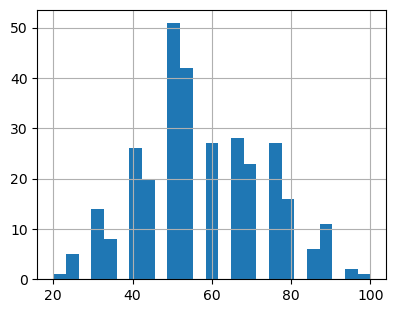

In [651]:
# Избавимся от выбросов и посмотрим распределение
df = df.loc[df.score > 10]
df.score.hist(bins=25)
df.score.describe()

# 4. Корреляционный анализ

Некоторые признаки могут быть сильно скоррелированы друг с другом. Это означает, что между этими признаками есть некоторая линейная зависимость. Если зависимость большая - часть скоррелированных признаков (не все) следует убрать из выборки, так как они несут избыточную информацию. **Посчитаем матрицу корреляции и построим pairplot и heatmap.**

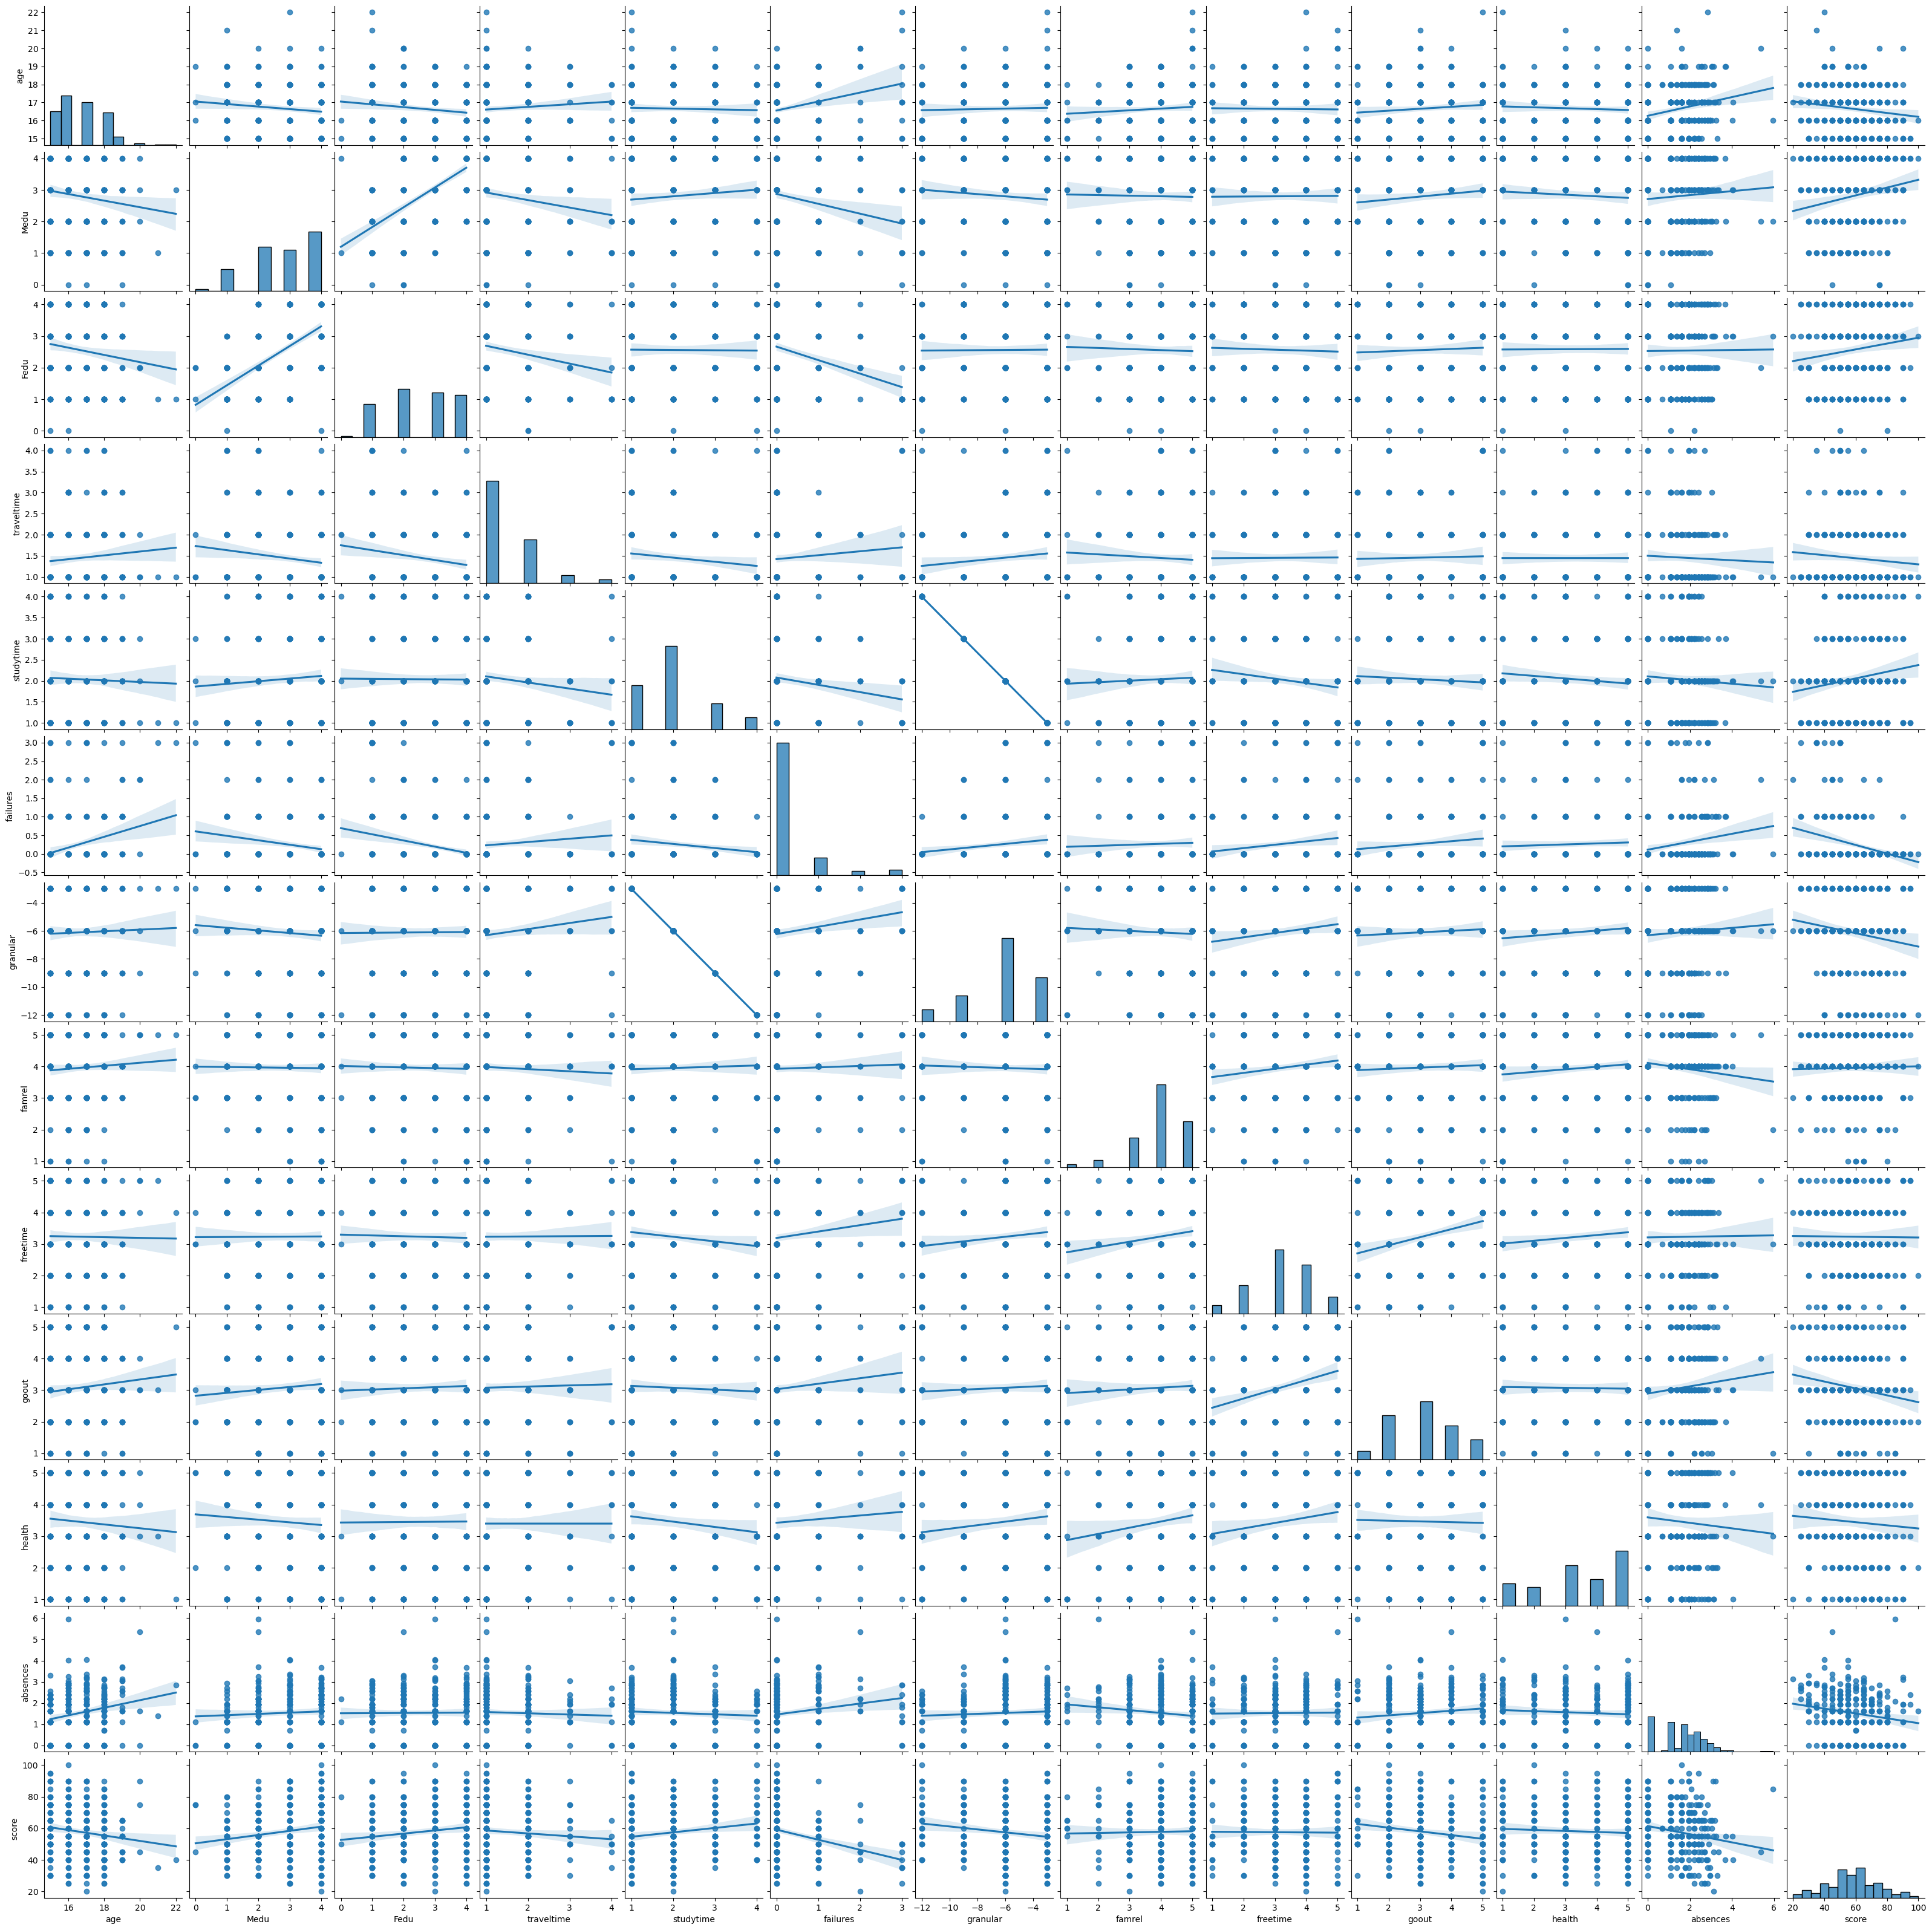

In [300]:
sns.pairplot(df, kind='reg')

In [652]:
df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.120544,-0.132904,0.081953,-0.029029,0.268951,0.029029,0.067594,-0.013682,0.091383,-0.054718,0.215375,-0.135764
Medu,-0.120544,1.000000,0.623277,-0.153984,0.081203,-0.193629,-0.081203,-0.015481,0.006043,0.093004,-0.064927,0.060477,0.180558
Fedu,-0.132904,0.623277,1.000000,-0.181685,-0.007760,-0.266626,0.007760,-0.027716,-0.027693,0.037420,0.006017,0.008078,0.136063
traveltime,0.081953,-0.153984,-0.181685,1.000000,-0.119623,0.091287,0.119623,-0.054459,0.005918,0.023772,-0.000081,-0.039531,-0.081853
studytime,-0.029029,0.081203,-0.007760,-0.119623,1.000000,-0.138870,-1.000000,0.037804,-0.123678,-0.047060,-0.100978,-0.054154,0.149390
failures,0.268951,-0.193629,-0.266626,0.091287,-0.138870,1.000000,0.138870,0.035149,0.136043,0.111910,0.055280,0.166638,-0.272112
granular,0.029029,-0.081203,0.007760,0.119623,-1.000000,0.138870,1.000000,-0.037804,0.123678,0.047060,0.100978,0.054154,-0.149390
famrel,0.067594,-0.015481,-0.027716,-0.054459,0.037804,0.035149,-0.037804,1.000000,0.147663,0.047466,0.125532,-0.115497,0.020343
freetime,-0.013682,0.006043,-0.027693,0.005918,-0.123678,0.136043,0.123678,0.147663,1.000000,0.273381,0.124335,0.011048,-0.009284
goout,0.091383,0.093004,0.037420,0.023772,-0.047060,0.111910,0.047060,0.047466,0.273381,1.000000,-0.017961,0.110837,-0.160280


Из анализа очевидно, что столбец granular обратно пропорционален столбцу studytime, избавимся от него.

In [653]:
df.corr().applymap(lambda x: x if x > 0.5 else '')

,age,Medu,Fedu,traveltime,studytime,failures,granular,famrel,freetime,goout,health,absences,score
age,1.0,,,,,,,,,,,,
Medu,,1.0,0.623277,,,,,,,,,,
Fedu,,0.623277,1.0,,,,,,,,,,
traveltime,,,,1.0,,,,,,,,,
studytime,,,,,1.0,,,,,,,,
failures,,,,,,1.0,,,,,,,
granular,,,,,,,1.0,,,,,,
famrel,,,,,,,,1.0,,,,,
freetime,,,,,,,,,1.0,,,,
goout,,,,,,,,,,1.0,,,


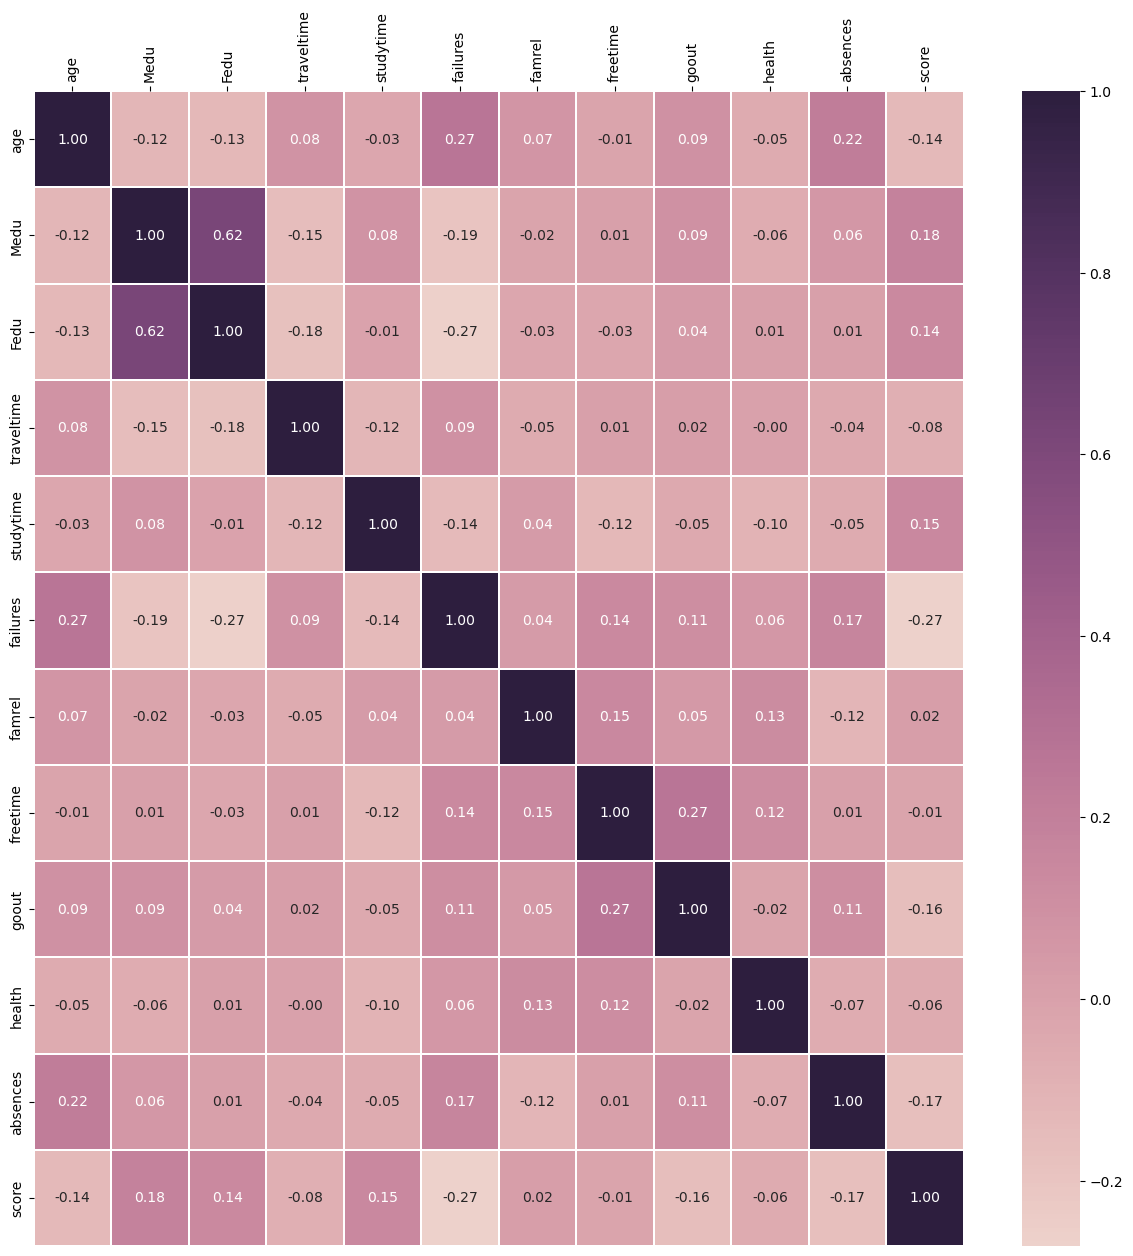

In [654]:
# Удалим столбец granular
df = df.drop('granular', axis=1)

# Построим таблицу heatmap
plt.rcParams['figure.figsize'] = (15,15)
ax = sns.heatmap(df.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), linewidth=.1, fmt=".2f")
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(rotation=90)

<AxesSubplot:>

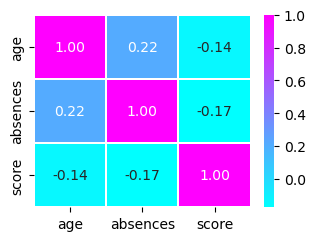

In [655]:
# Рассмотрим подближе корреляцию только для числовых столбцов.
col_list = []
for col in df.columns:
    if (df[col].dtype !='object') and (len(df[col].unique()) > 6):
        col_list.append(col)

plt.rcParams['figure.figsize'] = (3.5, 2.5)
sns.heatmap(df[col_list].corr(), annot=True, cmap = 'cool', linewidth=.1, fmt='.2f')

График показывает, что возраст отрицательно коррелирует с целевой переменной

In [656]:
df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.120544,-0.132904,0.081953,-0.029029,0.268951,0.067594,-0.013682,0.091383,-0.054718,0.215375,-0.135764
Medu,-0.120544,1.000000,0.623277,-0.153984,0.081203,-0.193629,-0.015481,0.006043,0.093004,-0.064927,0.060477,0.180558
Fedu,-0.132904,0.623277,1.000000,-0.181685,-0.007760,-0.266626,-0.027716,-0.027693,0.037420,0.006017,0.008078,0.136063
traveltime,0.081953,-0.153984,-0.181685,1.000000,-0.119623,0.091287,-0.054459,0.005918,0.023772,-0.000081,-0.039531,-0.081853
studytime,-0.029029,0.081203,-0.007760,-0.119623,1.000000,-0.138870,0.037804,-0.123678,-0.047060,-0.100978,-0.054154,0.149390
failures,0.268951,-0.193629,-0.266626,0.091287,-0.138870,1.000000,0.035149,0.136043,0.111910,0.055280,0.166638,-0.272112
famrel,0.067594,-0.015481,-0.027716,-0.054459,0.037804,0.035149,1.000000,0.147663,0.047466,0.125532,-0.115497,0.020343
freetime,-0.013682,0.006043,-0.027693,0.005918,-0.123678,0.136043,0.147663,1.000000,0.273381,0.124335,0.011048,-0.009284
goout,0.091383,0.093004,0.037420,0.023772,-0.047060,0.111910,0.047466,0.273381,1.000000,-0.017961,0.110837,-0.160280
health,-0.054718,-0.064927,0.006017,-0.000081,-0.100978,0.055280,0.125532,0.124335,-0.017961,1.000000,-0.065864,-0.056890


In [657]:
# Корреляция признаков с целевой переменной
round(df.corr().score.abs().sort_values(ascending=False),2)

score         1.00
failures      0.27
Medu          0.18
absences      0.17
goout         0.16
studytime     0.15
Fedu          0.14
age           0.14
traveltime    0.08
health        0.06
famrel        0.02
freetime      0.01
Name: score, dtype: float64

- Признаки не сильно коррелируют друг с другом. Это может быть хорошим знаком для построения модели, однако осутствие сильной корреляции с целевой переменной - вовсе не позитивный факт.  

- Сортировка признака "score" по значению модуля коэффициента корреляции не учитывает, что переменные в этом столбце не являются абсолютно независимыми. Для устранения этого недостатка используем значение коэффициента детерминации (доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью). В зависимости от наличия определённых переменных в модели, связь между содержащимися в ней переменными и целевым параметром прослеживается наилучшим образом.

In [658]:
# Рекурсивно переберём все сочетания переменных
variables = {'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                'famrel', 'freetime', 'goout', 'health', 'absences'}

# Найдём такой набор признаков, при котором коэффициент детерминации (R-squared) будет максимальным
bruteforce_variables = set()
BruteForce(variables, '', bruteforce_variables)
bruteforce_variables.remove('')
bruteforce_variables

{'Medu + freetime + failures + Fedu + age + traveltime + studytime',
 'Medu + health + Fedu + studytime + failures',
 'Medu + absences + freetime + failures + age + goout',
 'health + famrel + failures + Fedu + traveltime',
 'absences + freetime + failures + traveltime + studytime + goout',
 'Medu + health + freetime + Fedu + failures + goout',
 'Medu + absences + freetime + goout',
 'Medu + absences + Fedu + failures + age',
 'Medu + absences + failures + Fedu + traveltime + studytime',
 'Medu + health + absences + famrel + studytime + failures + age + goout',
 'health + famrel + failures + age + studytime + goout',
 'health + famrel + freetime + traveltime + goout',
 'Medu + health + absences + freetime + traveltime + studytime + goout',
 'health + absences + famrel + freetime + failures + Fedu + studytime + goout',
 'Medu + absences + Fedu + failures + traveltime',
 'Medu + health + famrel + failures + traveltime + studytime + goout',
 'health + famrel + freetime + failures + age + 

In [659]:
results = {}
# Посчитаем Adjusted R-Squared для каждого сочетания признаков
for variable_set in bruteforce_variables:
    lin_model = sm.ols(formula = 'score ~ ' + variable_set, data=df).fit()
    results[variable_set] = f'{lin_model.rsquared_adj:.3}'
    
# Выведем отсортированные результаты 
vrbls_R_squared_set = sorted(results.items(), key = lambda x: x[1], reverse =True)
for elem in vrbls_R_squared_set:
    print(elem[1], '\t', elem[0])
        

0.157 	 Medu + absences + failures + traveltime + studytime + goout
0.157 	 Medu + absences + studytime + failures + traveltime + goout
0.155 	 Medu + absences + Fedu + studytime + failures + traveltime + goout
0.155 	 Medu + absences + failures + Fedu + traveltime + studytime + goout
0.155 	 Medu + absences + Fedu + failures + traveltime + studytime + goout
0.153 	 Medu + absences + studytime + failures + age + traveltime + goout
0.153 	 Medu + absences + famrel + studytime + failures + traveltime + goout
0.153 	 Medu + absences + failures + age + traveltime + studytime + goout
0.153 	 Medu + absences + famrel + failures + traveltime + studytime + goout
0.152 	 Medu + absences + Fedu + studytime + failures + age + traveltime + goout
0.152 	 Medu + absences + Fedu + failures + age + traveltime + studytime + goout
0.152 	 Medu + absences + failures + Fedu + age + traveltime + studytime + goout
0.152 	 Medu + absences + famrel + failures + Fedu + traveltime + studytime + goout
0.152 	 Me

**Комбинация признаков: "failures + absences + Medu + goout + studytime + traveltime" показала наиболее высокий R-squared. Оставим ее.**

# 5. Анализ номинативных переменных

In [660]:
# Найдем статистические различия с помощью парного t-теста с использованием поправки Бонферони
for col in df.columns:
    if df[col].dtype == 'object':
        stat_dif_bonf(df, col, 'score')

- Найдены статистически значимые различия для переменной "address": R, U.
- Найдены статистически значимые различия для переменной "Mjob": health, at_home.
- Найдены статистически значимые различия для переменной "Fjob": teacher, other.
- Найдены статистически значимые различия для переменной "Fjob": teacher, services.
- Найдены статистически значимые различия для переменной "schoolsup": yes, no.


**В проведенном анализе использовалась поправка Бонферони на множественные сравнения.  
Её довольно часто критикуют в связи с излишней консервативностью.** 

## Используем критерий Тьюки:

In [661]:
columns_in = []

for col in df.columns:
    if df[col].dtype == 'object':
        columns_in.append(col)

stat_dif_tukey(df, columns_in, 'score', 10, 0.05)

,group1,group2,meandiff,p-adj,lower,upper,reject,feature
1,R,U,4.9038,0.0290,0.5066,9.3011,True,address
1,at_home,health,10.6602,0.0405,0.2912,21.0293,True,Mjob
9,other,teacher,10.3213,0.0212,1.0212,19.6214,True,Fjob
10,services,teacher,10.7877,0.0251,0.8816,20.6938,True,Fjob
1,no,yes,-10.1503,0.0001,-15.2693,-5.0313,True,schoolsup


Найдены статистически значимые различия в: 
Fjob         2
address      1
Mjob         1
schoolsup    1
Name: feature, dtype: int64


### Проверка с использованием критрия Тьюки показала аналогичные результаты. 

## Рассмотрим более детально переменные Fjob, address, Mjob, schoolsup:

### Переменная 'Fjob':

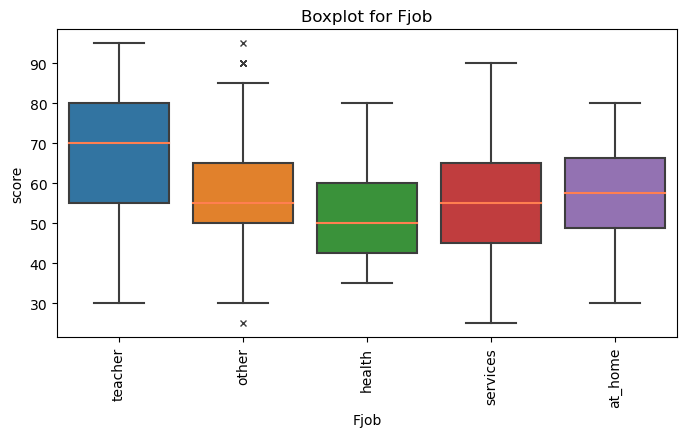

In [662]:
get_boxplot(df, 'Fjob', 'score')

Различия в группах:  
- **teacher**	и **other**    
- **teacher** и **services**   

**Можно сделать вывод, что ученики, чьи отцы работают учителями, показывают более высокие результаты в учебе, чем те школьники, чьи отцы, работают на госслужбе или имеют другую, не включённую в перечень, профессию.**

### Переменная 'Mjob':

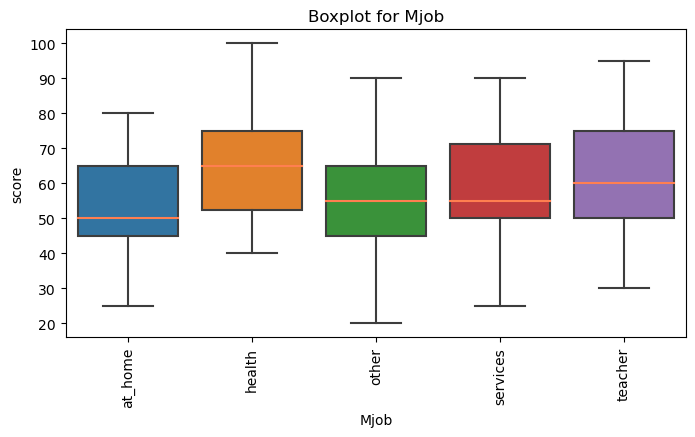

In [663]:
get_boxplot(df, 'Mjob', 'score')

Различия в группах:  
- **health** и **at_home**    

**Можно сделать вывод, что ученики, чья мать работает в сфере здравоохранения, в среднем учатся лучше, чем ученики, чья мать не работает.**

### Переменная 'address': 

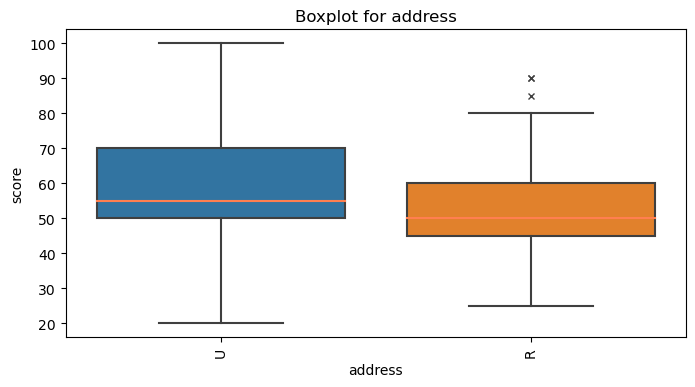

In [664]:
get_boxplot(df, 'address', 'score')

**Можно сделать вывод, что ученики, проживающие в городе в среднем имеют более высокую успеваемость, чем ученики, проживающие за городом.**

### Переменная 'schoolsup': 

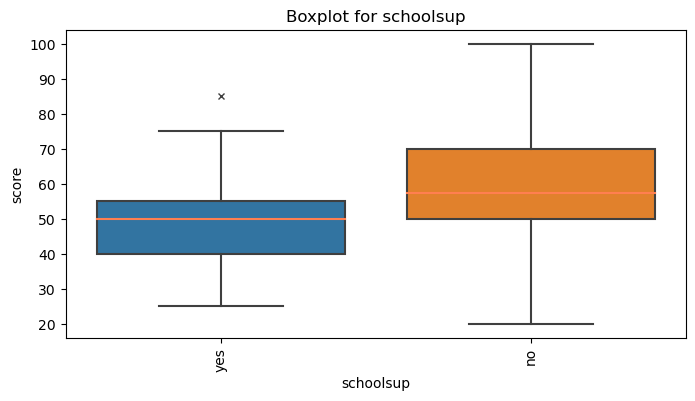

In [665]:
get_boxplot(df, 'schoolsup', 'score')

**Можно сделать вывод, что ученики без дополнительной образовательной поддержки в среднем сдают экзамены лучше, чем с ней.  
Это может свидетельствовать о том, что поддержку оказывают более слабым ученикам.**

# 6. Выводы

- Данные достаточно чистые, выбросы найдены в столбцах "Fedu" и "score".  
- Наблюдается приемлемое количество пропусков (не более 11,4%), которые можно заменить наиболее частотными значениями.   
- Неинформативный столбец "granular" повторяет признак "studytime" с обратной корреляцией.


### Зависимости, которые будут использованы в модели  

**Числовые переменные:**

- С единичным увеличением "failures" целевой параметр изменяется на -0.272112 (при неизменных остальных перменных).  
Ученики, имеющие больше внеучебных неудач, учатся хуже.  
- С единичным увеличением "Medu" целевой параметр возрастает на 0.180558.  
Чем более хорошее образование имеет мать ребенка, тем лучше его результаты в учебе.  
- С единичным увеличением "absences" целевой параметр изменяется на -0.172132.  
Чем больше ученики пропускают уроки, тем хуже они учатся.  
- С единичным увеличением "goout" целевой параметр изменяется на -0.160280.  
Чем больше времени ученики проводят с друзьями, тем менее эффективно они учатся.   
- С единичным увеличением "studytime" целевой параметр возрастает на 0.149390.  
Чем больше ученики уделяют внимание урокам, тем лучше они учатся. 
- С единичным увеличением "traveltime" целевой параметр изменяется на -0.081853.  
Ученики, живущие дальше от школы, менее успешны в учёбе.   

**Номинативные переменные:**  

- Ученики, чьи отцы работают учителями, показывают более высокие результаты в учебе чем те школьники, чьи отцы работают на госслужбе или имеют другую, не включённую в перечень, профессию.  
- Ученики, чьи матери работают в сфере здравоохранения, в среднем учатся лучше, чем ученики, чья мать не работает.  
- Ученики, проживающие в городе, в среднем имеют более высокую успеваемость, чем ученики, проживающие за городом.  
- Ученики, которые не пользуются дополнительной образовательной поддержкой в среднем имеют более высокие результаты в учебе, чем те ученики, которым оказывают такую поддержку. Это может свидетельствовать о том, что поддержку предоставляют более слабым ученикам.

### Парамерты, которые предлагается использовать для построения модели:
- числовые переменные: **failures, absences, Medu, traveltime, goout, studytime**  
- номинативные переменные: **Fjob, address, Mjob, schoolsup**

In [666]:
# Датасет для модели:
model_df = df.loc[:, ['failures', 'absences', 'Medu', 'traveltime','goout', 'studytime', 
            'Fjob', 'address', 'Mjob', 'schoolsup', 'score']]
model_df.head()

,failures,absences,Medu,traveltime,goout,studytime,Fjob,address,Mjob,schoolsup,score
0,0.0,1.945910,4.0,2.0,4.0,2.0,teacher,U,at_home,yes,30.0
1,0.0,1.609438,1.0,1.0,3.0,2.0,other,U,at_home,no,30.0
2,3.0,2.397895,1.0,1.0,2.0,2.0,other,U,at_home,yes,50.0
3,0.0,1.098612,4.0,1.0,2.0,3.0,NaN,U,health,no,75.0
4,0.0,1.609438,3.0,1.0,2.0,2.0,other,U,other,no,50.0
